In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
# %matplotlib inline
sns.set_theme()


data_dir = './data/'
seed = 42


 # Load Paysim1

In [2]:
# Load Banksim1
paysim = pd.read_csv(f'{data_dir}paysim1/PS_20174392719_1491204439457_log.csv')



In [3]:
print(f'Paysim Transactions {paysim.shape}')
paysim.head()


Paysim Transactions (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


 # Fraud distribution

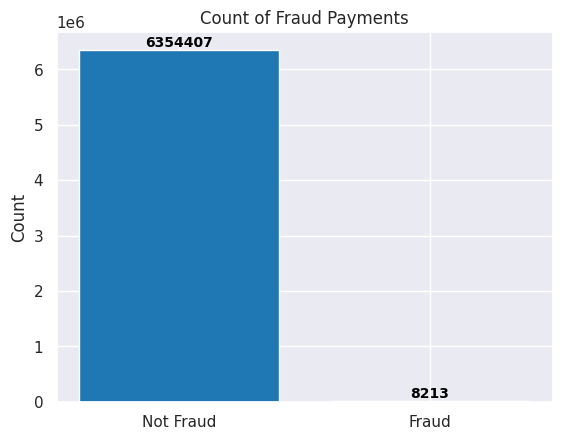

In [4]:
# Fraud 
fraud = paysim.isFraud.value_counts()
fig, ax = plt.subplots()
bars = ax.bar(['Not Fraud', 'Fraud'],fraud.values, color=['#1f77b4', '#d62728'])

# Add labels to the top of each bar
ax.bar_label(bars, labels=fraud.values, label_type='edge', color='black', fontsize=10, weight='bold')

# Customize the plot
ax.set_ylabel('Count')
ax.set_title('Count of Fraud Payments')
plt.show()


Text(0.5, 1.0, 'Amount Distribution - Max 92445516.64')

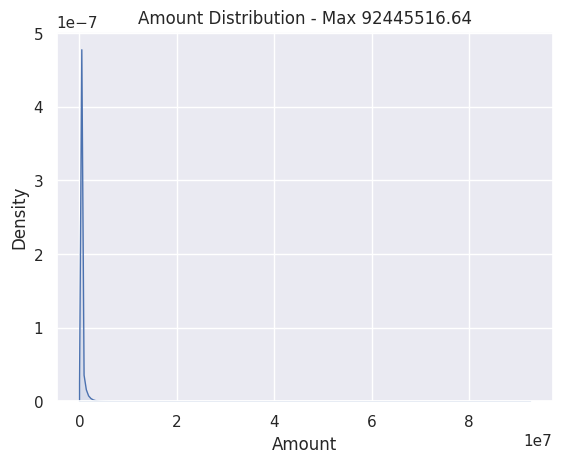

In [5]:
sns.kdeplot(data=paysim, x='amount', fill=True, alpha=0.1, linewidth=1)
plt.xlabel('Amount')
plt.ylabel('Density')
max_amount = max(paysim.amount)
plt.title(f'Amount Distribution - Max {max_amount}')


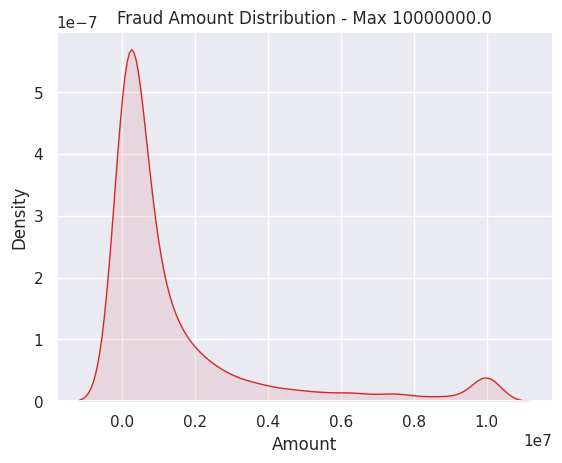

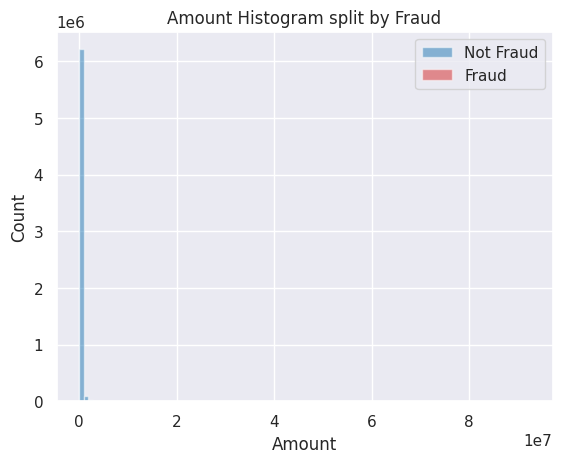

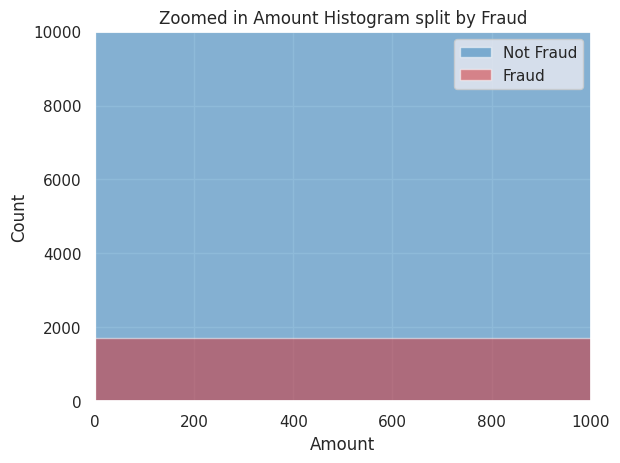

In [6]:
fraud = paysim.loc[paysim.isFraud== 1]
not_fraud = paysim.loc[paysim.isFraud== 0]

sns.kdeplot(data=fraud, x='amount', fill=True, color='#d62728', alpha=0.1, linewidth=1)
plt.xlabel('Amount')
plt.ylabel('Density')
max_amount = max(fraud.amount)
plt.title(f'Fraud Amount Distribution - Max {max_amount}')
plt.show()

plt.hist(not_fraud.amount, alpha=0.5,label='Not Fraud', bins=100, color='#1f77b4')
plt.hist(fraud.amount, alpha=0.5,label='Fraud', bins=100, color='#d62728')
plt.title('Amount Histogram split by Fraud')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.hist(not_fraud.amount, alpha=0.5,label='Not Fraud', bins=100, color='#1f77b4')
plt.hist(fraud.amount, alpha=0.5,label='Fraud', bins=100, color='#d62728')
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.title('Zoomed in Amount Histogram split by Fraud')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.legend()
plt.show()




 # Split Data

In [8]:
def label_encode(data, cat_cols):
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])
    return label_encoders

def label_decode(data, encoders):
    for col, encoder in encoders.items():
        data[col] = encoder.inverse_transform(data[col])

# Clean up data
data = paysim
print(data.nunique())
# data = data.drop(['zipcodeOri', 'zipMerchant'],axis=1) # drop single value columns
# data.age = pd.to_numeric(data.age.str.strip("'"), errors='coerce').fillna(-1).astype(int) # convert age to numbers, U's turn into -1's
cat_cols = ['type','nameOrig', 'nameDest']
label_encoders = label_encode(data, cat_cols)
data.dtypes

# Split data
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=seed, shuffle=True, stratify=y)


step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64


 # Create Random Forest

In [9]:
rand_forest = RandomForestClassifier(random_state=seed)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)


# Evaluate Results

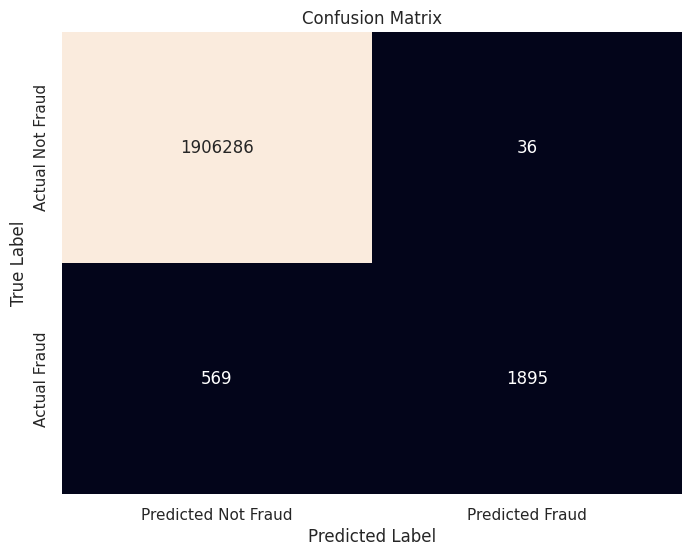

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



In [12]:
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix for better visualization
cm_df = pd.DataFrame(cm, index=['Actual Not Fraud', 'Actual Fraud'], columns=['Predicted Not Fraud', 'Predicted Fraud'])

# Plot the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_test,y_pred))

